# Imagenet Example

This notebook illustrates the use of the proposed in(n)vestigation methods on the ImageNet dataset for a pretrained VGG16.

# Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import time
import imp
import os

import keras
import keras.backend
import keras.models
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.optimizers import RMSprop

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis

eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Using TensorFlow backend.


# Load model

Load the pretrained VGG16 net with ReLUs.

In [3]:
# Parameter
netname = "vgg16"
pattern_type = "relu"

In [4]:
# Build Model

channels_first = keras.backend.image_data_format == "channels_first"

tmp = getattr(innvestigate.applications.imagenet, netname)
net = tmp(load_weights=True, load_patterns=pattern_type)
model = keras.models.Model(inputs=net["in"], outputs=net["out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")
modelp = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
modelp.compile(optimizer="adam", loss="categorical_crossentropy")

# Test data

Get a few (preselected) example images from the ImageNet dataset. In order to load your choice of images from the ImageNet dataset, place them into `innvestigate/examples`.

In [5]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(
    net["image_shape"][0])

# Analysis

Use several methods to in(n)vestigate and visualize the learned classifier on the example images.

Hereby the analyse method containing name, optional parameter, postprocessing information and a title for the final visualisation is passed into the framework by a n-tuple. The available methods are subdivided into three groups depending on their principal approach: gradient-based, pattern-based and relevance-based investigation methods. For a full list of methods please refer to the script in `innvestigate/innvestigate/analyzer/__init__.py`.

In [6]:
# Create list of in(n)vestigation methods we want to apply to the trained model, if applicable specify optional 
# parameters

methods = [
    # NAME             POSTPROCESSING     TITLE

    # Show input.
    ("input",                 {},                            imgnetutils.image,   "Input"),

    # Function
    ("gradient",              {},                            imgnetutils.graymap, "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},           imgnetutils.graymap, "SmoothGrad"),
    ("integrated_gradients",  {},                            imgnetutils.graymap, ("Integrated", "Gradients")),

    # Signal
    ("deconvnet",             {},                            imgnetutils.bk_proj, "Deconvnet"),
    ("guided_backprop",       {},                            imgnetutils.bk_proj, ("Guided", "Backprop"),),
    ("pattern.net",           {"patterns": net["patterns"]}, imgnetutils.bk_proj, "PatterNet"),

    # Interaction
    ("pattern.attribution",   {"patterns": net["patterns"]}, imgnetutils.heatmap, "Pattern", "Attribution"),
    ("lrp.epsilon",           {},                            imgnetutils.heatmap, "LRP Epsilon"),
    ("lrp.composite_a",       {},                            imgnetutils.heatmap, "LRP CompositeA"),
    ("lrp.composite_b",       {},                            imgnetutils.heatmap, "LRP CompositeB")
]

In [7]:
# Create analyzers.
analyzers = []
print('Create analyzer for ', flush=True)
for method in methods:
    print('{} '.format(''.join(method[3])), flush=True)
    analyzers.append(innvestigate.create_analyzer(method[0], 
                                                  model, 
                                                  **method[1]))

# Apply analyzers to trained VGG model.
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None
analysis = np.zeros([len(images), len(analyzers), 224, 224, 3])
text = []
for i, (image, y) in enumerate(images):
    image = image[None, :, :, :]
    # Predict label.
    x = imgnetutils.preprocess(image, net)
    presm = model.predict_on_batch(x)[0]
    prob = modelp.predict_on_batch(x)[0]
    y_hat = prob.argmax()

   # Save label, pre-softmax activation, probabilistic output and predicted label for plots
    text.append(("%s" %label_to_class_name[y], "%.2f" %presm.max(), 
                 "%.2f" % prob.max(), "%s" %label_to_class_name[y_hat]))
    
    for aidx, analyzer in enumerate(analyzers):
        # Measure execution time
        t_start = time.time()
        print('{} '.format(''.join(methods[aidx][-1])), end='', flush=True)
        
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        a = analyzer.analyze(image if is_input_analyzer else x)
        
        t_elapsed = time.time() - t_start
        print('({:.4f}s) '.format(t_elapsed), end='', flush=True)
        
        # Postprocess.
        if not np.all(np.isfinite(a)):
            print("Image %i, analysis of %s not finite: nan %s inf %s" %
                  (i, methods[aidx][3],
                   np.any(np.isnan(a)), np.any(np.isinf(a))))
        if not is_input_analyzer:
            a = imgnetutils.postprocess(a, color_conversion, channels_first)
        a = methods[aidx][2](a)
        analysis[i, aidx] = a[0]
        
# Clear session.
if keras.backend.backend() == 'tensorflow':
    keras.backend.clear_session()

Create analyzer for 
Input 
Gradient 
SmoothGrad 
IntegratedGradients 
Deconvnet 
GuidedBackprop 
PatterNet 
Pattern 
LRP Epsilon 
LRP CompositeA 
LRP CompositeB 
Input (0.0154s) Gradient (1.7469s) SmoothGrad (120.1282s) IntegratedGradients (124.2734s) Deconvnet (4.1934s) GuidedBackprop (2.2186s) PatterNet (9.5687s) Attribution (12.3050s) LRP Epsilon (3.3040s) LRP CompositeA (7.4865s) LRP CompositeB (12.3811s) Input (0.0013s) Gradient (1.8345s) SmoothGrad (128.1952s) IntegratedGradients (110.5236s) Deconvnet (1.7676s) GuidedBackprop (1.7975s) PatterNet (7.9336s) Attribution (1.6861s) LRP Epsilon (1.6435s) LRP CompositeA (4.0200s) LRP CompositeB (7.1476s) Input (0.0022s) Gradient (1.7274s) SmoothGrad (108.2339s) IntegratedGradients (105.0085s) Deconvnet (1.6917s) GuidedBackprop (1.6988s) PatterNet (1.7133s) Attribution (1.7274s) LRP Epsilon (1.7276s) LRP CompositeA (4.1043s) LRP CompositeB (7.2026s) Input (0.0025s) Gradient (1.7087s) SmoothGrad (105.4903s) IntegratedGradients (104.7436s

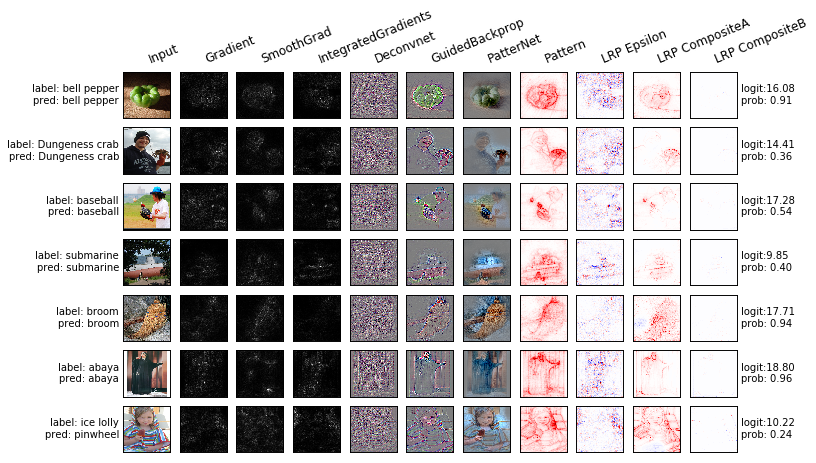

In [8]:
# Plot the analysis.

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
row_labels = text
col_labels = [''.join(method[3]) for method in methods]

eutils.plot_image_grid(grid, 
                       row_labels, 
                       col_labels)